In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd

from neuromaps.datasets import fetch_fslr
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, detrend, hilbert
from scipy.linalg import norm
from brainspace.utils.parcellation import reduce_by_labels
from scipy.stats import ks_2samp
from heteromodes.restingstate import ModelBOLD
from heteromodes.utils import load_hmap

In [2]:
bold_data = h5py.File(f"{PROJ_DIR}/data/empirical/HCP_unrelated-445_rfMRI_hemi-L_nsubj-50_parc-glasser360_BOLD.hdf5", 'r')
bold_emp = bold_data['bold']
nregions, nt, nsubjs = np.shape(bold_emp)
print(bold_emp.shape)

(180, 1200, 50)


In [3]:
# Load network assignments
network_labels = np.loadtxt(f"{PROJ_DIR}/data/parcellations/Demirtas2019_NetworkLabels.L.txt", dtype=str)
network_labels = [label.split("-")[0] for label in network_labels]
net_names = ["AUD", "VIS", "SOM", "DAN", "FPN", "VAN", "DMN", "CON", "Other"]

den = "4k"
fslr = fetch_fslr(den)
surf = str(fslr["midthickness"][0])
parc_file = f"{PROJ_DIR}/data/parcellations/Q1-Q6_RelatedParcellation210.L.CorticalAreas_dil_Colors.{den}_fs_LR.label.gii"
parc_glasser = nib.load(parc_file).darrays[0].data.astype(int)
medmask = np.where(parc_glasser != 0, True, False)
# Get the Glasser labels (len 32k)
parc_glasser = parc_glasser[medmask] - 1

# Get the network labels for each vertex
network_mapping = {net: i for i, net in enumerate(net_names)}
print(network_mapping)
network_parc = np.array([network_mapping[net] for net in network_labels])

{'AUD': 0, 'VIS': 1, 'SOM': 2, 'DAN': 3, 'FPN': 4, 'VAN': 5, 'DMN': 6, 'CON': 7, 'Other': 8}


In [4]:
def calc_phase_fcd(bold, tr=0.72, network=None):
    """Calculate phase-based functional connectivity dynamics (phFCD).

    This function calculates the phase-based functional connectivity dynamics (phFCD) 
    between regions of interest using the given bold signal and repetition time (TR).

    Parameters
    ----------
    bold : numpy.ndarray
        The bold signal data of shape (N, T), where N is the number of regions and T is the number of time points.
    tr : float
        The repetition time (TR) in seconds.

    Returns
    -------
    numpy.ndarray
        The phFCD matrix of shape (M,), where M is the number of unique pairs of regions.
    """

    # Define parameters
    k = 2  # 2nd order butterworth filter
    fnq = 0.5 * 1/tr  # tr must be in seconds
    flp = 0.04  # low-pass frequency of filter
    fhi = 0.07  # high-pass frequency of the filter
    Wn = [flp/fnq, fhi/fnq]  # butterworth bandpass non-dimensional frequency
    bfilt2, afilt2 = butter(k, Wn, btype="bandpass")  # construct the filter
    _, t = np.shape(bold)  # N = number of regions, T = number of time points

    # Standardise and detrend the data if it isn't already
    if not np.allclose(np.mean(bold, axis=1), 0) or not np.allclose(np.std(bold, axis=1), 1.0):
        scaler = StandardScaler()
        bold = scaler.fit_transform(bold.T).T
    bold = detrend(bold, axis=1, type='constant')
    # Apply the filter to the data
    bold_filtered = filtfilt(bfilt2, afilt2, bold, axis=1)
    # Calculate phase for each region
    phase_bold = np.angle(hilbert(bold_filtered))

    # Remove first 9 and last 9 time points to avoid edge effects from filtering, as the bandpass 
    # filter may introduce distortions near the boundaries of the time series. The cutoff is 
    # arbitrarily chosen
    t_trunc = np.arange(9, t - 9)

    # If no region_subsets is provided, treat all regions as a single subset
    if network is None:
        network = np.zeros(bold.shape[0], dtype=int)

    fcd = []
    for i in np.unique(network):
        region_indices = np.where(network == i)[0]
        phase_subset = phase_bold[region_indices, :]

        # Calculate synchrony
        tril_ind = np.tril_indices(len(region_indices), -1)
        nt = len(t_trunc)
        synchrony_vec = np.zeros((nt, len(tril_ind[0])))
        for t_ind, t in enumerate(t_trunc):
            phase_diff = phase_subset[:, t][:, None] - phase_subset[:, t]
            synchrony_mat = np.cos(phase_diff)
            synchrony_vec[t_ind, :] = synchrony_mat[tril_ind]

        # Calculate phase from synchrony at each time point
        p_mat = np.zeros((nt - 2, synchrony_vec.shape[1]))
        for t_ind in range(nt - 2):
            p_mat[t_ind, :] = np.mean(synchrony_vec[t_ind:t_ind + 3, :], axis=0)
            p_mat[t_ind, :] = p_mat[t_ind, :] / norm(p_mat[t_ind, :])

        # Calculate phase for every time pair
        fcd_mat = p_mat @ p_mat.T

        triu_ind = np.triu_indices(fcd_mat.shape[0], k=1)
        fcd.append(fcd_mat[triu_ind])

    return np.array(fcd)

In [5]:
fcd_emp, fcd_emp_net = [], []
for i in range(nsubjs):
    fcd_emp.append(calc_phase_fcd(bold_emp[:, :, i], tr=0.72, network=None))
    fcd_emp_net.append(calc_phase_fcd(bold_emp[:, :, i], tr=0.72, network=network_parc))

fcd_emp = np.hstack(fcd_emp).flatten()
fcd_emp_net = np.dstack(fcd_emp_net)

## Homogeneous model

In [6]:
# Initialise model
model_rs = ModelBOLD(surf_file=surf, medmask=medmask)
model_rs.calc_modes(500)

bold_hom = np.empty((nregions, nt, 5))
for i in range(5):
    ext_input = np.load(f"{PROJ_DIR}/data/resting_state/extInput_den-{den}_randseed-{i}.npy")
    bold_hom_vert = model_rs.run_rest(ext_input=ext_input)
    bold_hom[:, :, i] = reduce_by_labels(bold_hom_vert, parc_glasser, axis=1)

In [7]:
fcd_hom, fcd_hom_net = [], []
for i in range(5):
    fcd_hom.append(calc_phase_fcd(bold_hom[:, :, i], tr=0.72, network=None))
    fcd_hom_net.append(calc_phase_fcd(bold_hom[:, :, i], tr=0.72, network=network_parc))

fcd_hom = np.hstack(fcd_hom).flatten()
fcd_hom_net = np.dstack(fcd_hom_net)

## Heterogeneous model

In [8]:
# Initialise model
hmap = load_hmap("myelinmap", den)
model_rs_het = ModelBOLD(surf_file=surf, medmask=medmask, hmap=hmap, alpha=0.8)
model_rs_het.calc_modes(500)

bold_het = np.empty((nregions, nt, 5))
for i in range(5):
    ext_input = np.load(f"{PROJ_DIR}/data/resting_state/extInput_den-{den}_randseed-{i}.npy")
    bold_het_vert = model_rs_het.run_rest(ext_input=ext_input)
    bold_het[:, :, i] = reduce_by_labels(bold_het_vert, parc_glasser, axis=1)

In [9]:
fcd_het, fcd_het_net = [], []
for i in range(5):
    fcd_het.append(calc_phase_fcd(bold_het[:, :, i], tr=0.72, network=None))
    fcd_het_net.append(calc_phase_fcd(bold_het[:, :, i], tr=0.72, network=network_parc))

fcd_het = np.hstack(fcd_het).flatten()
fcd_het_net = np.dstack(fcd_het_net)

## Plot results

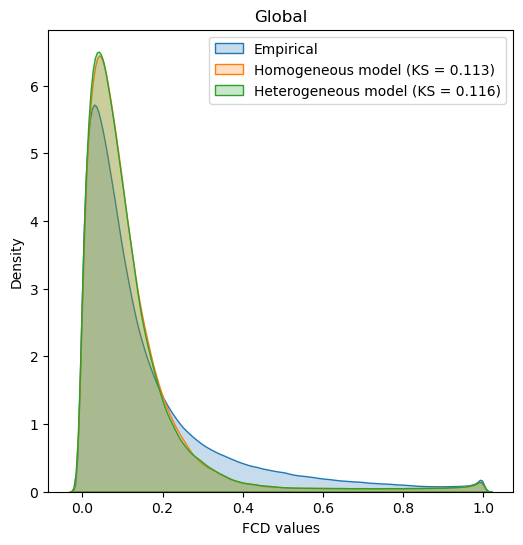

In [10]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(fcd_emp.flatten(), label="Empirical", fill=True)
fcd_ks_hom = ks_2samp(fcd_emp.flatten(), fcd_hom.flatten())[0]
sns.kdeplot(fcd_hom.flatten(), label=f"Homogeneous model (KS = {fcd_ks_hom:.3f})", fill=True)
fcd_ks_het = ks_2samp(fcd_emp.flatten(), fcd_het.flatten())[0]
sns.kdeplot(fcd_het.flatten(), label=f"Heterogeneous model (KS = {fcd_ks_het:.3f})", fill=True)
plt.title(f"Global")
plt.xlabel("FCD values")
plt.ylabel("Density")
plt.legend()

In [11]:
# Note: this takes ~5 mins to run
hom_ks, het_ks = [], []
for i in range(np.shape(fcd_emp_net)[0]):
    hom_ks.append(ks_2samp(fcd_emp_net[i, :, :].flatten(), fcd_hom_net[i, :, :].flatten())[0])
    het_ks.append(ks_2samp(fcd_emp_net[i, :, :].flatten(), fcd_het_net[i, :, :].flatten())[0])

Plotting FCD distribution for AUD network...
Plotting FCD distribution for VIS network...
Plotting FCD distribution for SOM network...
Plotting FCD distribution for DAN network...
Plotting FCD distribution for FPN network...
Plotting FCD distribution for VAN network...
Plotting FCD distribution for DMN network...
Plotting FCD distribution for CON network...
Plotting FCD distribution for Other network...


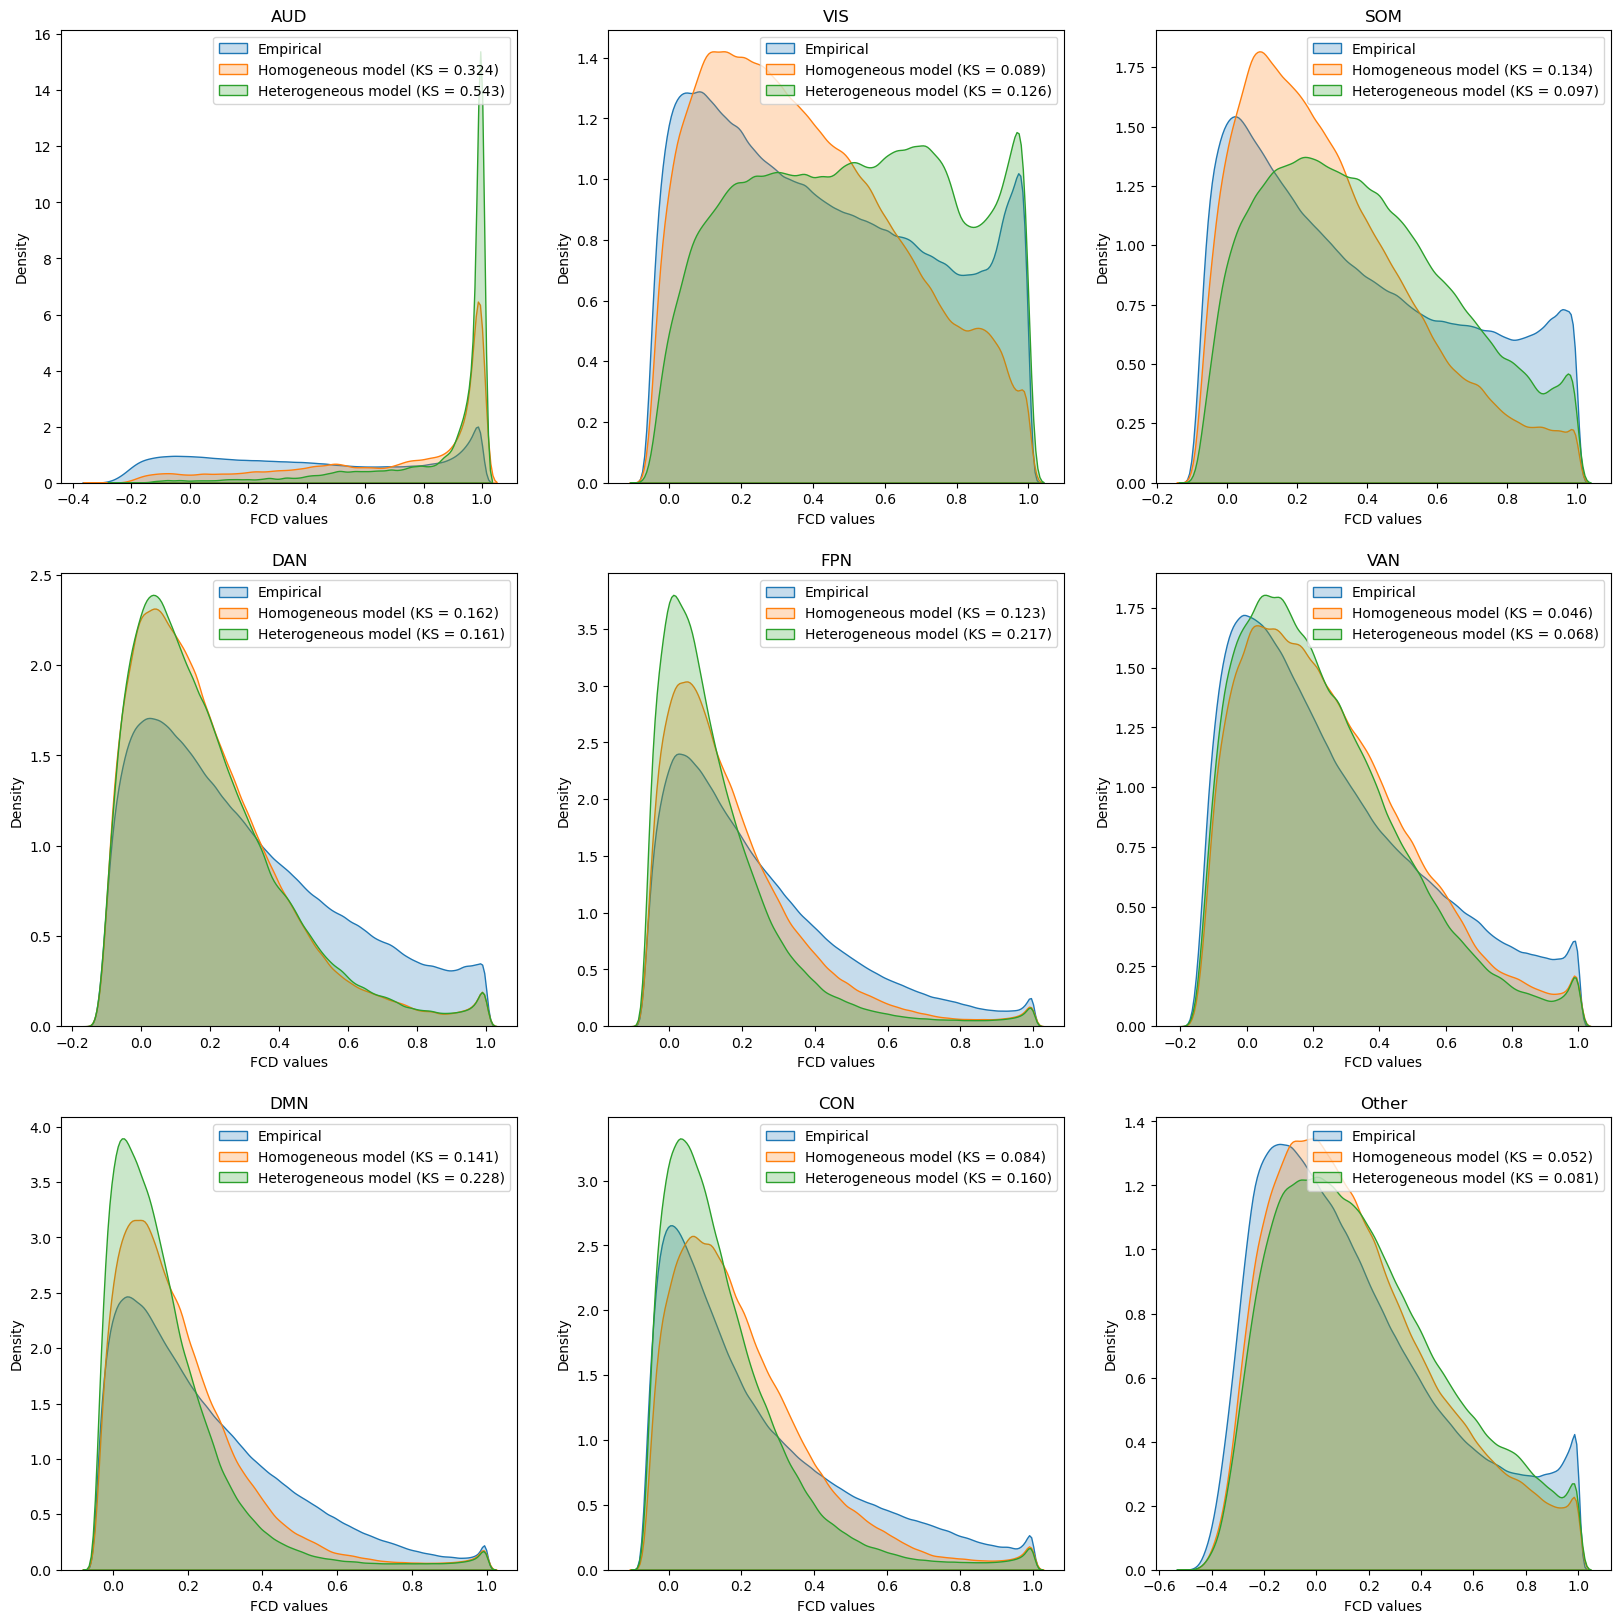

In [12]:
# This cell takes ~7 mins to run

# Plot fcd distributions for each network
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

for i, ax in enumerate(axs):
    print(f"Plotting FCD distribution for {net_names[i]} network...")
    sns.kdeplot(data=fcd_emp_net[i, :, :].flatten(), label="Empirical", fill=True, ax=ax)
    sns.kdeplot(data=fcd_hom_net[i, :, :].flatten(), label=f"Homogeneous model (KS = {hom_ks[i]:.3f})", fill=True, ax=ax)
    sns.kdeplot(data=fcd_het_net[i, :, :].flatten(), label=f"Heterogeneous model (KS = {het_ks[i]:.3f})", fill=True, ax=ax)
    
    ax.set_xlabel("FCD values")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_title(net_names[i])

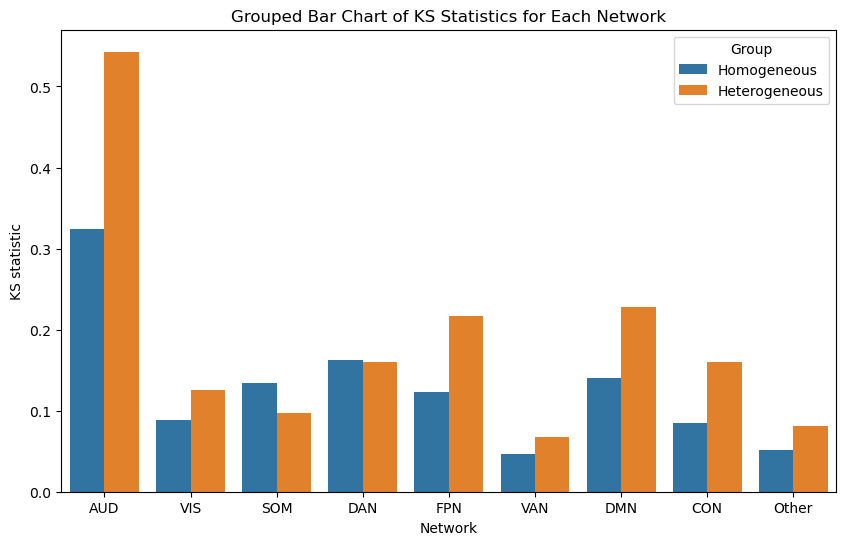

In [13]:
import pandas as pd

# Plot seaborn bar chart of KS scores
df = pd.DataFrame({
    "Network": net_names * 2,
    "KS Statistic": np.concatenate([hom_ks, het_ks]),
    "Group": ["Homogeneous"] * len(hom_ks) + ["Heterogeneous"] * len(het_ks)
})

plt.figure(figsize=(10, 6))
sns.barplot(x="Network", y="KS Statistic", hue="Group", data=df)
# Add labels and title
plt.title('Grouped Bar Chart of KS Statistics for Each Network')
plt.ylabel('KS statistic')
plt.xlabel('Network')

plt.show()